# Example 3 – INP: monodisperse vs lognormal size distributions

This example explores how the assumed size distribution of ice-nucleating particles
(INPs) affects predicted freezing behavior.

We compare two populations that have the **same total ice-nucleating surface area**
but different size distributions:

- A **monodisperse** population (all particles same size).
- A **lognormal** population (broad size distribution).

Both are passed through the same ice nucleation parameterization, and we compare the
resulting frozen fractions.

### What you’ll learn

- How to construct INP populations using `build_population` and
  `build_freezing_population`.
- How to sample an ice-nucleating surface area (INSA) distribution.
- How differences in size distribution alone can affect predicted freezing.

## Step 1 – Define an INSA distribution and build baseline population

We first construct a synthetic **ice-nucleating surface area (INSA)** distribution that roughly follows the example from Alpert & Knopf (2016). Here, INSA is expressed as surface area per particle.

From this INSA distribution, we will create two idealized populations:

- A **monodisperse** population where all particles have the same INSA.
- A **lognormal** population that preserves the *total* INSA but redistributes it across a range of particle sizes.

This lets us isolate the impact of size distribution on freezing, holding total INSA fixed.


In [1]:
from part2pop.population import build_population
import numpy as np
import warnings
from part2pop.viz.style import StyleManager, Theme
from part2pop.viz.builder import build_plotter
import matplotlib.pyplot as plt
%matplotlib inline  

warnings.filterwarnings("ignore")

# sample a lognormal INSA distribution to match the example in 
# P. A. Alpert and D. A. Knopf: A unifying ice nucleation model
INSA = np.random.lognormal(mean=np.log(1e-9), 
                          sigma=np.log(10.0), 
                          size=3000)
Dps = list(2.0*np.sqrt(INSA/(4*np.pi)))
Ns = []
aero_spec_names = []
aero_spec_fracs = []
for Dp in Dps:
    aero_spec_names.append(["SO4"])
    aero_spec_fracs.append([1.0])
    Ns.append(1e9/len(Dps))

# @Payton -- the purpose of these tutorials is to show how the population-builders work
lognormal_cfg = {"type": "monodisperse",
                 "N": Ns,
                 "D": Dps,
                 "aero_spec_names": aero_spec_names,
                 "aero_spec_fracs": aero_spec_fracs,
                 "species_modifications": {'SO4': {'m_log10Jhet': 0.0, 'b_log10Jhet': 7.0}}            
}

monodisperse_cfg = {"type": "monodisperse",
                    "N": [1e9],
                    "D": [1.78e-5], #1.271095275775258e-05],
                    "aero_spec_names":[["SO4"]],
                    "aero_spec_fracs":[[1.0]],
                    "species_modifications": {'SO4': {'m_log10Jhet': 0.0, 'b_log10Jhet': 7.0}}            
}

# Build underlying particle populations
pop_configs = [lognormal_cfg, monodisperse_cfg]
lognorm_pop = build_population(lognormal_cfg)
mono_pop = build_population(monodisperse_cfg)


## Step 2 – Attach a freezing parameterization

Next we use `build_freezing_population` to wrap each size distribution with a freezing
parameterization.

The configuration (`var_cfg`) specifies:

- The **morphology** (e.g. `homogeneous` vs other modes).
- Any **temperature** or **supersaturation** grids to evaluate.
- Any additional parameters required by the chosen parameterization.

The result is a `Population` that can be queried for freezing metrics such as frozen
fraction as a function of temperature.


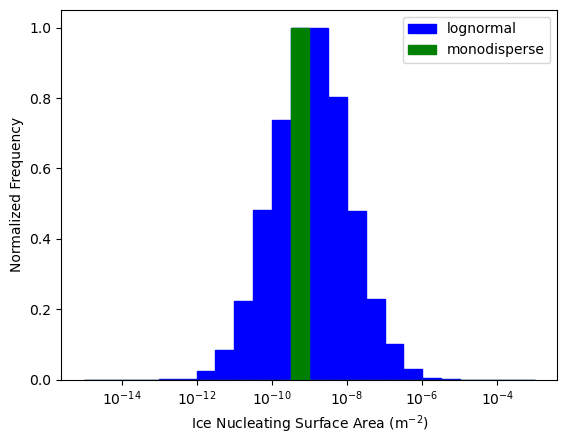

In [2]:
# plot the ice nucleating surface area distribution

from part2pop.freezing import build_freezing_population

var_cfg = {"morphology": "homogeneous",
            "T_grid": [-30],
            "T_units": "C",
            "species_modifications": {'SO4': {'m_log10Jhet': 0.0, 'b_log10Jhet': 7.0}}
}

# Build freezing config from variable cfg and population Jhets
frz_cfg = dict(var_cfg)

# Build population of FreezingParticles
monodisperse_frz_pop = build_freezing_population(mono_pop, frz_cfg)
lognormal_frz_pop = build_freezing_population(lognorm_pop, frz_cfg)

# Ice nucleating surface area distribution
bins = np.logspace(-15, -3, 25)

# Calculate histogram for lognormal population
counts, bins = np.histogram(lognormal_frz_pop.INSA[0], weights=lognormal_frz_pop.num_concs, bins=bins)
max_count = counts.max()
weights = lognormal_frz_pop.num_concs / max_count
plt.hist(lognormal_frz_pop.INSA[0], bins=bins, weights=weights, alpha=1.0, color='blue', edgecolor='blue', label='lognormal')

# Calculate histogram for monodisperse population
counts, bins = np.histogram(monodisperse_frz_pop.INSA[0], weights=monodisperse_frz_pop.num_concs, bins=bins)
max_count = counts.max()
weights = monodisperse_frz_pop.num_concs / max_count

# todo: put this into a state plotter
plt.hist(monodisperse_frz_pop.INSA[0], bins=bins, weights=weights, alpha=1.0, color='green', edgecolor='green', label='monodisperse')


plt.legend()
plt.ylabel('Normalized Frequency')
plt.xlabel(r'Ice Nucleating Surface Area (m$^{-2}$)')
plt.xscale('log')


## Step 3 – Evaluate frozen fraction vs temperature

Here we evaluate the frozen fraction for each population over a temperature range. Because the two populations share the same total INSA, any differences in the curves are purely due to how that INSA is distributed in size.

Questions to ask:

- Does the monodisperse population freeze more or less efficiently than the lognormal?
- Are differences largest at colder or warmer temperatures?


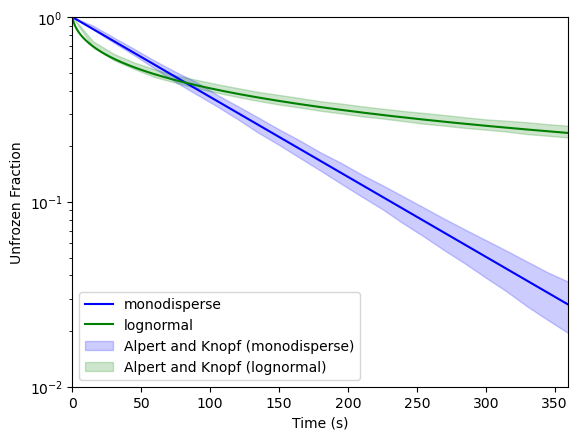

In [ ]:
# Plot the expected unfrozen fraction over time, where P_frz = 1-np.exp(-Jhet*INSA*dt)

time = np.linspace(0, 360, 3601)
N_frz_monodisperse = np.zeros((len(time), monodisperse_frz_pop.num_concs.shape[0]))
N_frz_lognormal = np.zeros((len(time), lognormal_frz_pop.num_concs.shape[0]))
for ii, (dt) in enumerate(time):
    N_frz_monodisperse[ii] = monodisperse_frz_pop.num_concs*(1-np.exp(-monodisperse_frz_pop.Jhet*monodisperse_frz_pop.INSA*dt))
    N_frz_lognormal[ii] = lognormal_frz_pop.num_concs*(1-np.exp(-lognormal_frz_pop.Jhet*lognormal_frz_pop.INSA*dt))
monodisperse_F_unfrz = (np.sum(monodisperse_frz_pop.num_concs)-np.sum(N_frz_monodisperse, axis=1))/np.sum(monodisperse_frz_pop.num_concs)
lognormal_F_unfrz = (np.sum(lognormal_frz_pop.num_concs)-np.sum(N_frz_lognormal, axis=1))/np.sum(lognormal_frz_pop.num_concs)
# FIXME: use plotter
plt.plot(time, monodisperse_F_unfrz, '-b', label='monodisperse')
plt.plot(time, lognormal_F_unfrz, '-g', label='lognormal')

# Data taken from P. A. Alpert and D. A. Knopf: A unifying ice nucleation model
# FIXME: put this in a CSV under "examples/exmple_data/[appropriately named folder]/"
time = np.array([0.0, 14.98691375,29.98429651,44.98167926,59.97644476,74.96335851,89.97644476,104.979062,119.9842965,134.968593,149.968593,164.9764448,179.9816793,194.9921483,209.9842965,224.9869138,239.979062,254.9842965,269.9816793,284.979062,299.9816793,314.9764448,329.9816793,344.9764448,359.9738275])
monodisperse = np.array([[1.0,0.856423967,0.72762932,0.621005681,0.525361514,0.445184599,0.382056167,0.328618534,0.280134925,0.23656128,0.20331975,0.17312942,0.147676415,0.125362888,0.106799787,0.091305329,0.076571617,0.06499828,0.054668066,0.046377042,0.038907872,0.032824749,0.027220942,0.022966481,0.019482243],
                         [1.0,0.898735084,0.775282282,0.671491689,0.57905705,0.505308274,0.445040514,0.379540098,0.330077281,0.285743056,0.246950843,0.215096015,0.185472797,0.162557253,0.140478479,0.123184704,0.107214863,0.093246953,0.081042403,0.070882157,0.062153519,0.054478027,0.047581006,0.04155254,0.036984846]])
lognormal = np.array([[1.0,0.68730479,0.584873301,0.522938452,0.472537264,0.441665826,0.412829513,0.389601318,0.369616342,0.351819269,0.336484021,0.324039302,0.311302877,0.301278253,0.290625869,0.282634546,0.273787982,0.26481037,0.258518951,0.251409055,0.246078359,0.240162785,0.232804513,0.22801203,0.223193395],
                      [1.0,0.739398489,0.632643488,0.567518778,0.521048017,0.483439337,0.457838435,0.433707263,0.412936736,0.393749694,0.379326279,0.365280912,0.350795014,0.340643467,0.329485219,0.319819875,0.310686728,0.303084227,0.295388678,0.287209248,0.27982526,0.275153565,0.269872697,0.263467006,0.258534778]])

# FIXME: why does your model yield a single value at each time, while Alpert and Knopf have a distribution? Is your model incomplete?
plt.fill_between(time, monodisperse[0], monodisperse[1], color='b', alpha=0.2, label='Alpert and Knopf (monodisperse)')
plt.fill_between(time, lognormal[0], lognormal[1], color='g', alpha=0.2, label='Alpert and Knopf (lognormal)')
  
                 
plt.yscale('log')
plt.ylim(1e-2, 1e0)
plt.xlim(0, 360)
plt.ylabel('Unfrozen Fraction')
plt.xlabel('Time (s)')
plt.legend()
plt.show()


@Payton -- explain what the next step is doing. Are you sure this is correct?

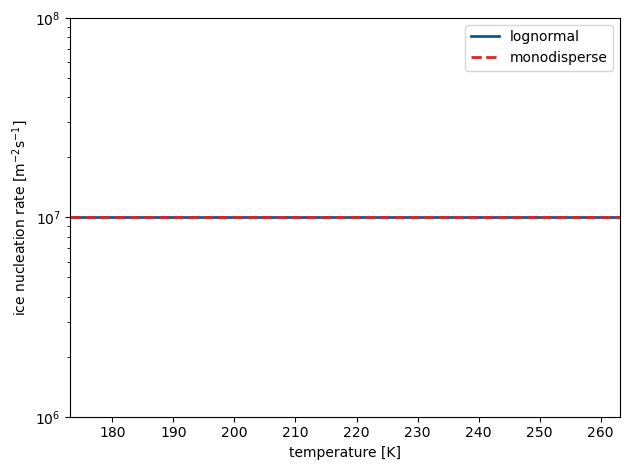

In [6]:
# plot the heterogeneous ice nucleation rate vs. temperature using viz package
mgr = StyleManager(Theme(), deterministic=True)

series = [
    {"key": "lognorm", "population": lognorm_pop, "label": r"lognormal"},
    {"key": "mono", "population": mono_pop, "label": r"monodisperse"},
]
line_styles = mgr.plan("line", [s["key"] for s in series])
line_styles['mono']['linestyle'] = '--'  # make monodisperse dashed line]

fig, ax = plt.subplots()
for s in series:
    cfg = {"varname": "avg_Jhet",
            "var_cfg": {"T_grid": np.linspace(-100, -10, 50), "T_units": "C",
                        "species_modifications": s["population"].species_modifications,
                        "morphology": "homogeneous"},  # simple case: single x
            "style": line_styles[s["key"]],
    }
    plotter = build_plotter("state_line", cfg)
    plotter.plot(s["population"], ax, label=s["label"])
ax.legend(); fig.tight_layout()
plt.show()

@Payton -- explain what the next step is doing

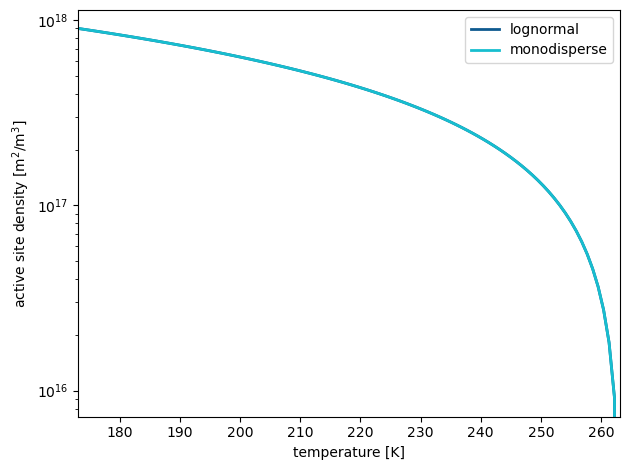

In [ ]:
# plot the ice nucleating active site density vs. temperature using viz package
# active site density is an intrinsic property, is not dependent on size or number
fig, ax = plt.subplots()
for s in series:
    cfg = {"varname": "nucleating_sites",
            "var_cfg": {"T_grid": np.linspace(-100, -10, 100),
                        "cooling_rate": -1.0, "T_units": "C",
                        "species_modifications": s["population"].species_modifications,
                        "morphology": "homogeneous"},  # simple case: single x
            "style": line_styles[s["key"]],
    }
    plotter = build_plotter("state_line", cfg)
    plotter.plot(s["population"], ax, label=s["label"])
ax.legend(); fig.tight_layout()
plt.show()


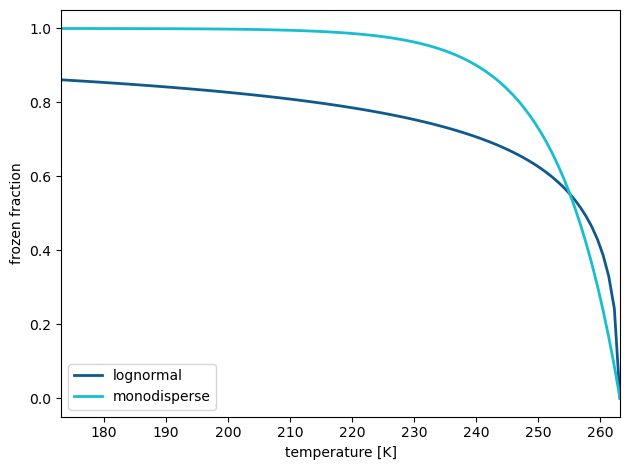

In [ ]:
# plot the frozen fraction vs. temperature at a given cooling rate using viz package
fig, ax = plt.subplots()
for s in series:
    cfg = {"varname": "frozen_frac",
            "var_cfg": {"T_grid": np.linspace(-100, -10, 100),
                        "cooling_rate": -0.1, "T_units": "C",
                        "species_modifications": s["population"].species_modifications,
                        "morphology": "homogeneous"},  # simple case: single x
            "style": line_styles[s["key"]],
    }
    plotter = build_plotter("state_line", cfg)
    plotter.plot(s["population"], ax, label=s["label"])
ax.legend(); fig.tight_layout()
plt.show()

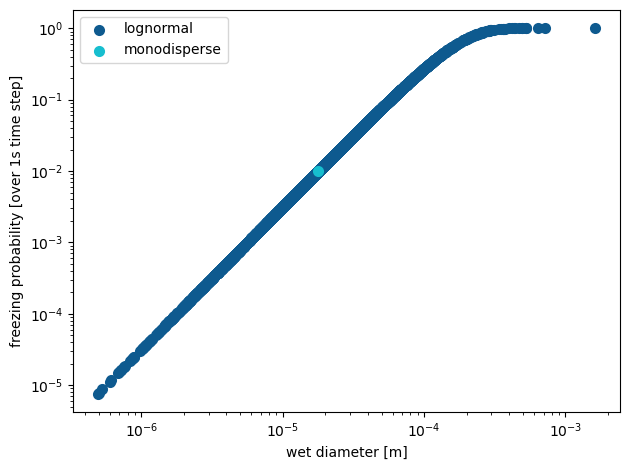

In [ ]:
# plot per-particle freezing probability over 1 s vs. size using viz package
fig, ax = plt.subplots()
for s in series:
    cfg = {"xvar": "Dwet",
            "yvar": "P_frz",
            "var_cfg": {"species_modifications": s["population"].species_modifications,
                        "T": -60, "T_units": "C"},
            "style": line_styles[s["key"]],
    }
    plotter = build_plotter("state_scatter", cfg)
    plotter.plot(s["population"], ax, label=s["label"])
ax.legend(); fig.tight_layout()
plt.show()